In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
# csv files for answer responses
gdrive_path = "/Users/dorislee/Google Drive/Turn/user_study/evaluation_study/transcription_and_analysis/"

In [4]:
user_task =  pd.read_csv(gdrive_path+"UserTaskAssignment.csv")

In [5]:
%load_ext autoreload
%autoreload 2
from paper_visualization import *

In [6]:
def dcg(r, k, method=0,debug=False):
    # alternative formulation of DCG places stronger emphasis on retrieving relevant documents
    r = np.asfarray(r)[:k]
    val = 0
    for i in range(1,len(r)+1):
        val+= (r[i-1]) / np.log2(i+1)
        if debug:
            print ("i=",i,":",(r[i-1]) ,"/", np.log2(i+1))
            print ((r[i-1]) / np.log2(i+1))
    return val

def ndcg(ground_truth_r,r, k,debug=False):
    return dcg(r, k,debug=debug) / dcg(ground_truth_r,k,debug=debug)

In [7]:
police_cramerV = [0.043252698,0.078885213,0.194386209,0.11183598,0.348153187,0.045002727,0.081185272]

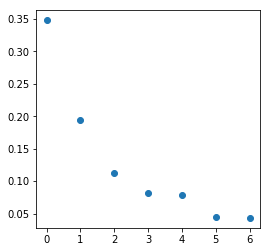

In [8]:
plt.plot(sorted(police_cramerV,reverse=True),'o')

In [9]:
# autism_cramerV = [60.87247643,66.8546435,134.96984,153.3636096,200.5987625,243.8487911,85.34491148,38.48316423,281.3288672,103.0945431]
# plt.plot(sorted(autism_cramerV,reverse=True),'o')

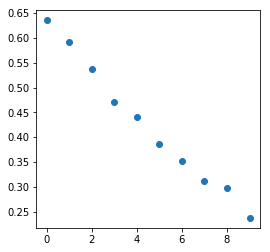

In [10]:
autism_cramerV = [0.297627607,0.311381722,0.441073719,0.469945188,0.537004338,0.592090951,0.351428625,0.237160611,0.635575801,0.385917085]
plt.plot(sorted(autism_cramerV,reverse=True),'o')

In [11]:
from sklearn import metrics

In [12]:
import copy

In [13]:
def PRF_at_k(binarize_ground_truth_r,r, k,debug=False):
    binarize_ground_truth_r = np.array(binarize_ground_truth_r)
    r = np.array(r)
    #print (binarize_ground_truth_r,r)
    assert len(r)==len(binarize_ground_truth_r)
    #coerce ground truth to binary (i.e. if ranking above k then relevant, if below k then marked as irrelevant)
    binarize_r = np.where(r>k, 0, 1)
    srt_r = copy.deepcopy(r)
    srt_r = sort(srt_r)[:k]
    binarize_r = []
    for x in r:
        if x in srt_r:
            binarize_r.append(1)
        else : 
            binarize_r.append(0)
    #print (binarize_ground_truth_r,binarize_r)
    #assert len(binarize_r)==len(binarize_ground_truth_r)
    p,r,fscore,_ = metrics.precision_recall_fscore_support(binarize_ground_truth_r,binarize_r,average='binary')
    
    #p = tp/(tp+fp)
    #r = tr/(tr+fn)
    ap = metrics.average_precision_score(binarize_ground_truth_r,binarize_r,average=None)
    return p,r, fscore,ap

In [14]:
# p,r,f,ap = PRF_at_k([1,2,3,4,5],[1,1,2,2,1],3)
# print (p,r)
# # assert (p,r,f==[0,0,0])

In [15]:
ground_truth_ratings = [1,2,3,4,5,6]
example_ratings = [3,2,3,0,1,2]
ideal_ordering = [3,3,3,2,2,2,1,0]
assert np.isclose(dcg(example_ratings,6),6.861,1e-2) #check DCG calculation (Based on Wikipedia example)
assert np.isclose(ndcg(ideal_ordering,[3,2,3,0,1,2],6),0.785,1e-2) #check NDCG calculation (Based on Wikipedia example)
assert np.isclose(ndcg([3,1,2],[3, 1, 2],3),1) #sanity check

In [18]:
# p,r,f,ap = PRF_at_k(ground_truth_ratings,example_ratings,1)
# assert (p,r,f==[0,0,0])
# p,r,f,ap = PRF_at_k(ground_truth_ratings,example_ratings,len(example_ratings))
# assert (p,r,f==[1,1,1])

In [19]:
# p_lst = []
# r_lst = []
# for k in range(1,len(example_ratings)+1):
#     p,r,f = PRF_at_k(ground_truth_ratings,example_ratings,k)
#     p_lst.append(p)
#     r_lst.append(r)

# plt.plot(r_lst,p_lst,'o')

In [20]:
# ndcg([3.0, 1.0, 2.0],[3.0, 2.0, 1.0],3,debug=True)

In [21]:
def compute_ndcg_rankings(user_ranking_filename,gt_ranking_filename):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)
    k = len(ground_truth_rank["attribute"])
    ground_truth_cramerV_rank = list(ground_truth_rank["cramerV"].rank(ascending=False)) 
    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
    else: 
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        user_rankings.append([task,ranking])
    #Computing ndcg ranking
    ndcg_data = []
    for trial in user_rankings:
        ndcg_d = []
        #print (trial)
        ndcg_d.append(trial[0])
        #for k in k_lst:
        ndcg_d.append(ndcg(ground_truth_cramerV_rank,trial[1],k))
#             print trial[1]
        ndcg_data.append(ndcg_d)
#    print ndcg_data
    NDCG_lst = ["NDCG@"+str(k)]
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task"]+NDCG_lst)
    #print (ndcg_result)
    return ndcg_result.groupby("Task",as_index=False).mean()

In [22]:
ndcg_result=[["Police"]+list(compute_ndcg_rankings("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")["NDCG@7"]),
["Autism"]+list(compute_ndcg_rankings("Ranking(Autism).csv","autism_ground_truth_correlation.csv")["NDCG@10"])]

In [23]:
import tabulate as T

In [24]:
print (T.tabulate(ndcg_result,headers=['Dataset','system','Cluster','BFS'],tablefmt='latex', floatfmt=".2f"))

\begin{tabular}{lrrr}
\hline
 Dataset   &   system &   Cluster &   BFS \\
\hline
 Police    &     0.32 &      0.28 &  0.37 \\
 Autism    &     0.19 &      0.29 &  0.20 \\
\hline
\end{tabular}


- NDCG@1 is 0 because if the first-ranked attribute is not retreived, then score would be 0.
- This makes sense, our algo does better than kmeans (2) and level-wise BFS (3), except for NDCG@3 A2 for some reason did very well.
- NDCG should be @10 because all users read through and ranked all 10 dashboards.

In [25]:
import scipy

In [26]:
def normalized_ranking(rank_list):
    nrank = []
    for rank in rank_list:
        normalized_rank = (float(rank)-min(rank_list))/(max(rank_list)-min(rank_list))
#         print normalized_rank
        nrank.append(normalized_rank)
    return nrank

In [27]:
from collections import Counter
from collections import OrderedDict

In [199]:
# user_ranking_filename = "Ranking(Police).csv"
# gt_ranking_filename = "ct_police_ground_truth_correlation.csv"
#     user_ranking_filename = "Ranking(Autism).csv"
#     gt_ranking_filename = "autism_ground_truth_correlation.csv"

def compute_prf_exclude_unranked(user_ranking_filename,gt_ranking_filename):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)
    cramerV = ground_truth_rank["cramerV"]
    #cutoff = min(cramerV)+((max(cramerV)-min(cramerV))/2)
    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
        cutoff=0.1
    else: 
        task_name = "Task2"
        cutoff=0.5
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    data = []
    max_data = []
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        user = row[1]["User"]
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        #Recompute the ground truth rating after throwing away unrated instances
        ranking = np.array(ranking)
        unrated_idxs =  np.where(ranking==0)[0]

        new_ranking = list(np.delete(ranking, unrated_idxs))
        new_CramerV = np.delete(np.array(ground_truth_rank["cramerV"]),unrated_idxs)
        #print (new_CramerV)
        assert len(new_ranking) == len(new_CramerV)
        #ground_truth_cramerV_rank = list(pd.Series(new_CramerV).rank(ascending=False)) 
        binarize_ground_truth_r = np.where(new_CramerV<cutoff, 0, 1)
        #print (binarize_ground_truth_r)
        #print (binarize_ground_truth_r, new_ranking)
        d = Counter(new_ranking)
        od = OrderedDict(sorted(d.items(), key=lambda t: t[0]))
        csum=0
        #Select a list of k values that are at the tie points 
        k_lst = []
        for key, value in od.items():
            csum+= value
            #print (csum)
            k_lst.append(csum)
        p_lst = []
        r_lst = [] 
        f_lst=[]
        ap_lst=[]
        #plt.figure()
        #loop through different k values
        for k in k_lst:
            p,r,f,ap=PRF_at_k(binarize_ground_truth_r,new_ranking,k)
            p_lst.append(p)
            r_lst.append(r)
            f_lst.append(f)
            ap_lst.append(ap)
            data.append([user,task,p,r,f,ap,k])
        # pick the result that yields the max value
        max_data.append([user,task,max(p_lst),max(r_lst),max(f_lst),max(ap_lst),k])
        #plt.plot(r_lst,p_lst,'.')
        #print (ground_truth_cramerV_rank, new_ranking,p,r,f,ap)
    result = pd.DataFrame(data,columns=["User","Task","P","R","F-Score","AP","k"])
    max_result = pd.DataFrame(max_data,columns=["User","Task","P","R","F-Score","AP","k"])
    return max_result,result

In [200]:
max_police_result, police_result = compute_prf_exclude_unranked("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")

In [201]:
best_ap = police_result.loc[autism_result.reset_index().groupby(["User","Task"])['AP'].idxmax()]
best_ap.groupby("Task",as_index=False).mean()[["Task","AP"]]

,Task,AP
0,A1,0.866667
1,A2,0.690741
2,A3,0.592063


In [202]:
best_f = police_result.loc[autism_result.reset_index().groupby(["User","Task"])['F-Score'].idxmax()]
best_f.groupby("Task",as_index=False).mean()[["Task","F-Score"]]
# best_f[["Task","F-Score"]].groupby("Task").std()

,Task,F-Score
0,A1,0.750000
1,A2,0.738889
2,A3,0.738571


In [152]:
max_autism_result, autism_result = compute_prf_exclude_unranked("Ranking(Autism).csv","autism_ground_truth_correlation.csv")

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/d

In [162]:
autism_result["AP"] = autism_result["AP"].fillna(0)

The warnings comes from the fact that for B3 a lot of users did not select things that were A5 and beyond, but the 3 most important attributes included in our cutoff were A5, A6 and A9, which they completely did not rate. 

In [163]:
# police_result.boxplot("F-Score",by="Task")

In [164]:
# police_result.groupby("Task",as_index=False).mean()

In [165]:
# autism_result.groupby(["Task"],as_index=False).mean()

In [166]:
# autism_result[autism_result["User"]==4]

In [190]:
best_ap = autism_result.loc[autism_result.reset_index().groupby(["User","Task"])['AP'].idxmax()]
best_ap.groupby("Task",as_index=False).mean()[["Task","AP"]]

,Task,AP
0,B1,0.600000
1,B2,0.665344
2,B3,0.200000


In [191]:
best_f = autism_result.loc[autism_result.reset_index().groupby(["User","Task"])['F-Score'].idxmax()]
best_f.groupby("Task",as_index=False).mean()[["Task","F-Score"]]
# best_f[["Task","F-Score"]].groupby("Task").std()

,Task,F-Score
0,B1,0.723016
1,B2,0.725000
2,B3,0.222222


In [99]:
# user_ranking_filename = "Ranking(Police).csv"
# gt_ranking_filename = "ct_police_ground_truth_correlation.csv"
def compute_exclude_unranked(user_ranking_filename,gt_ranking_filename,k):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)

    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
    else: 
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    ndcg_data = []
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        #Recompute the ground truth rating after throwing away unrated instances
        ranking = np.array(ranking)
        unrated_idxs =  np.where(ranking==0)[0]
        new_ranking = list(np.delete(ranking, unrated_idxs))
        new_CramerV = np.delete(np.array(ground_truth_rank["cramerV"]),unrated_idxs)
        assert len(new_ranking) == len(new_CramerV)
        ground_truth_cramerV_rank = list(pd.Series(new_CramerV).rank(ascending=False)) 
        #Computing ndcg ranking
#         k=4
        ndcg_k = len(new_ranking)
        ndcg_val=ndcg(ground_truth_cramerV_rank,new_ranking,ndcg_k)
        #p,r,f,ap=PRF_at_k(ground_truth_cramerV_rank,new_ranking,k)
        #print (ground_truth_cramerV_rank,new_ranking,ndcg_val)
        ndcg_data.append([task,ndcg_val,k])
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task","NDCG","k"])
    return ndcg_result

In [76]:
ndcg_result = compute_exclude_unranked("Ranking(Police).csv","ct_police_ground_truth_correlation.csv",3)
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG,k
0,A1,0.800910,3
1,A2,0.943029,3
2,A3,0.911349,3


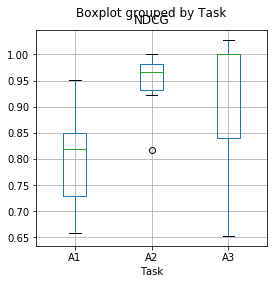

In [77]:
ndcg_result.boxplot("NDCG",by="Task")

In [45]:
ndcg_result = compute_exclude_unranked("Ranking(Autism).csv","autism_ground_truth_correlation.csv",4)

In [46]:
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG,k
0,B1,0.765871,4
1,B2,0.550991,4
2,B3,0.655138,4


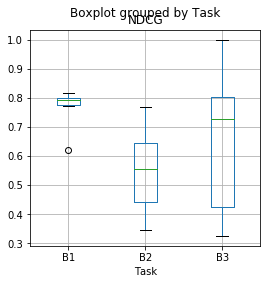

In [47]:
ndcg_result.boxplot("NDCG",by="Task")

# Dashboard attribute coverage

In [48]:
import glob
import json
dashboards = glob.glob("generated_dashboards/*")

In [49]:
dashboard_filters_attributes_only = []
univariate_only = []
for  dashboard_name in dashboards:
    dashboard = json.load(open(dashboard_name))
    dashboard_filters = []
    for id in dashboard.keys():
        if not (dashboard[id][-1]["filter"]=="#"):
            filters = dashboard[id][-1]["filter"].replace("$","=").split("#")[1:-1]
            dashboard_filters.append(filters)
    dashboard_name = dashboard_name.split("/")[1].split("_euclidean")[0]
    for dashbd in dashboard_filters:
        score = 1/len(dashbd)
        if (len(dashbd)==1):
            vis = dashbd[0]
            univariate_only.append([vis[:vis.index("=")],dashboard_name])
        for vis in dashbd:
            dashboard_filters_attributes_only.append([vis[:vis.index("=")],score,dashboard_name])

In [50]:
univariate_df =  pd.DataFrame(univariate_only,columns=["attribute","filename"])
univariate_df["Dataset"] = univariate_df["filename"].apply(lambda x: "autism" in x).apply(lambda x: {True:"Autism",False:"Police"}[x])
univariate_df["Condition"] = univariate_df["filename"].apply(lambda x: {"picking":"Storyboard","kmeans":"KMeans","levelwiseBFS":"BFS"}[x.split("_")[-1]])

In [51]:
univariate_df.groupby(["Dataset","Condition"],as_index=False).count()[["Dataset","Condition","attribute"]].rename(columns={"attribute":"# of Univariate Dashboards in "})

,Dataset,Condition,# of Univariate Dashboards in
0,Autism,BFS,9
1,Autism,KMeans,7
2,Autism,Storyboard,2
3,Police,BFS,9
4,Police,KMeans,3
5,Police,Storyboard,3


In [52]:
df = pd.DataFrame(dashboard_filters_attributes_only,columns=["attribute","%mentioned","filename"])

In [53]:
df["Dataset"] = df["filename"].apply(lambda x: "autism" in x).apply(lambda x: {True:"Autism",False:"Police"}[x])
df["Condition"] = df["filename"].apply(lambda x: {"picking":"Storyboard","kmeans":"KMeans","levelwiseBFS":"BFS"}[x.split("_")[-1]])

In [54]:
# df.groupby(["Dataset","Condition"],as_index=False).agg({"filename": pd.Series.nunique,"attribute":np.sum})

In [55]:
df.groupby(["Dataset","Condition"],as_index=False).count()[["Dataset","Condition","attribute"]].rename(columns={"attribute":"Number of Attributes Covered"})

,Dataset,Condition,Number of Attributes Covered
0,Autism,BFS,9
1,Autism,KMeans,12
2,Autism,Storyboard,19
3,Police,BFS,9
4,Police,KMeans,21
5,Police,Storyboard,16


In [56]:
# df.groupby(["Dataset","Condition","attribute"],as_index=False).sum()

# Exclude if not in univariate

In [57]:
user_ranking_filename = "Ranking(Police).csv"
gt_ranking_filename = "ct_police_ground_truth_correlation.csv"
def compute_ndcg_rankings_exclude_nonunivariate(user_ranking_filename,gt_ranking_filename):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)

    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
        dataset = "Police"
    else: 
        dataset = "Autism"
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    ndcg_data = []
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        #Find the idxs corresponding to attributes that are not shown as univariates in the dashboards to exclude
        attribute_order = list(user_rank.columns)[1:-2]
        condition = {"1":"Storyboard","2":"KMeans","3":"BFS"}[task[1]]
        univariate_coverage= list(univariate_df[(univariate_df["Dataset"]==dataset)&(univariate_df["Condition"]==condition)]["attribute"])
        univariate_coverage = [camelCaseToUnderscore(i) for i in univariate_coverage]
        exclude_idxs= []
        for univar in univariate_coverage:
            exclude_idxs.append(attribute_order.index(univar))
        exclude_idxs = np.array(exclude_idxs)
        #Recompute the ground truth rating after throwing away excluded instances
        ranking = np.array(ranking)
        new_ranking = list(np.delete(ranking, exclude_idxs))
        new_CramerV = np.delete(np.array(ground_truth_rank["cramerV"]),exclude_idxs)
        assert len(new_ranking) == len(new_CramerV)
        k = len(new_ranking)
        ground_truth_cramerV_rank = list(pd.Series(new_CramerV).rank(ascending=False)) 
        #Computing ndcg ranking
        ndcg_d = []
        ndcg_d.append(task)
        ndcg_val=ndcg(ground_truth_cramerV_rank,new_ranking,k)
        #print (ground_truth_cramerV_rank,new_ranking,ndcg_val)
        ndcg_d.append(ndcg_val)
        ndcg_d.append(k)
        ndcg_data.append(ndcg_d)
    #    print ndcg_data
    NDCG_lst = ["NDCG@k"]
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task","NDCG@k","k"])
    return ndcg_result

In [58]:
import re

In [59]:
def camelCaseToUnderscore(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [60]:
ndcg_result = compute_ndcg_rankings_exclude_nonunivariate("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG@k,k
0,A1,0.421912,4
1,A2,0.442083,4
2,A3,0.621848,4


In [61]:
ndcg_result = compute_ndcg_rankings_exclude_nonunivariate("Ranking(Autism).csv","autism_ground_truth_correlation.csv")
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG@k,k
0,B1,0.199252,8
1,B2,0.184723,4
2,B3,0.000000,5
